In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def dissolve_df(df, buffer_width=1e-4):
    dissolved = df.dissolve(by=f'DISTRICT_', aggfunc="sum").reset_index()
    dissolved = dissolved[['geometry', 'POP20', 'USH20_D', 'USH20_R']]
    dissolved['geometry'] = dissolved.buffer(buffer_width)
    dissolved['district'] = dissolved.index
    dissolved['district'] = dissolved['district'] + 1
    dissolved["Dem_PCT"] = round(
        dissolved['USH20_D']/(dissolved['USH20_D']+dissolved['USH20_R']), 4)*100
    return dissolved

In [3]:
actual_results = pd.read_excel("../redistricting/2022_congressional_voting_results.xlsx")
actual_results["district"] = actual_results["district"].astype(str)
states = actual_results["state"].unique()
run = "moving_knife_c" # "original_scorer_2020"

In [4]:
records = []
algo_dems = []
act_dems = []

for state in states:
    print("\n")
    print(state)
    state_results = actual_results.loc[actual_results["state"] == state]
    n_districts = len(state_results)

    algo_districts = gpd.read_file(f"../output/{state.lower()}_2020/{state.lower()}_2020_{run}.shp")

    algo_df = algo_districts.groupby("DISTRICT_")[['POP20', 'USH20_D', 'USH20_R']].sum().reset_index()
    algo_df['Dem_PCT'] = round(algo_df['USH20_D']/(algo_df['USH20_D']+algo_df['USH20_R'])*100,1)
    
    ## Party Vote
    actual_pv = state_results[["democrat"]].sum()/state_results[["democrat","republican"]].sum().sum()
    actual_pv = round(actual_pv.to_list()[0]*100,1)

    algo_pv = algo_df[["USH20_D"]].sum()/algo_df[["USH20_D","USH20_R"]].sum().sum()
    algo_pv = round(algo_pv.to_list()[0]*100,1)

    print(f"Party Vote (D, R): ({actual_pv}%, {100-actual_pv}%) | ({algo_pv}%, {100-algo_pv}%)")

    ## Seats Won
    actual_seats = state_results.loc[state_results["democrat"] > state_results["republican"]]
    actual_seats = len(actual_seats)

    algo_seats = algo_df.loc[algo_df["USH20_D"] > algo_df["USH20_R"]]
    algo_seats = len(algo_seats)
    print(f"Seats Won (D, R): ({actual_seats}, {n_districts-actual_seats}) | ({algo_seats}, {n_districts-algo_seats})")

    ## Proportional Seating
    actual_prop_seating = round(actual_pv/100. * n_districts)
    algo_prop_seating = round(algo_pv/100. * n_districts)
    print(f"Proportional Seating (D, R): ({actual_prop_seating}, {n_districts-actual_prop_seating}) | ({algo_prop_seating}, {n_districts-algo_prop_seating})")

    ## Competitiveness
    actual_non_comp = len(state_results.loc[(state_results["dem_share"] < 0.45) | (state_results["dem_share"] > 0.55)])
    actual_comp = len(state_results.loc[
        ((state_results["dem_share"] >= 0.45) & (state_results["dem_share"] < 0.475)) | ((state_results["dem_share"] >= 0.525) & (state_results["dem_share"] <= 0.55))
    ])
    actual_very_comp = len(state_results.loc[
        (state_results["dem_share"] >= 0.475) & (state_results["dem_share"] < 0.525)
    ])
    
    algo_non_comp = len(algo_df.loc[(algo_df["Dem_PCT"] < 45) | (algo_df["Dem_PCT"] > 55)])
    algo_comp = len(algo_df.loc[
        ((algo_df["Dem_PCT"] >= 45) & (algo_df["Dem_PCT"] < 47.5)) | ((algo_df["Dem_PCT"] >= 52.5) & (algo_df["Dem_PCT"] <= 55))
    ])
    algo_very_comp = len(algo_df.loc[
        (algo_df["Dem_PCT"] >= 47.5) & (algo_df["Dem_PCT"] < 52.5)
    ])

    print(f"Competitiveness (NC, C, C*): ({actual_non_comp}, {actual_comp}, {actual_very_comp}) | ({algo_non_comp}, {algo_comp}, {algo_very_comp})")

    ## Uncontested Seats
    uncontested_rep_seats = state_results.loc[(state_results['dem_share'] == 0)].shape[0]
    uncontested_dem_seats = state_results.loc[(state_results['dem_share'] == 1)].shape[0]
    print(f"Uncontested Seats (D, R): ({uncontested_dem_seats}, {uncontested_rep_seats})")

    algo_dems.extend(algo_df['Dem_PCT'].tolist())
    act_dems.extend(state_results['dem_share'].tolist())


    records.append({
        "State": state,
        "Seats": n_districts,
        "Act.DemShare": actual_pv,
        "Act.RepShare": 100-actual_pv,
        "Algo.DemShare": algo_pv,
        "Algo.RepShare": 100-algo_pv,
        "Act.DemSeatsWon": actual_seats,
        "Act.RepSeatsWon": n_districts-actual_seats,
        "Algo.DemSeatsWon": algo_seats,
        "Algo.RepSeatsWon": n_districts-algo_seats,
        "Act.NonCompetitive": actual_non_comp,
        "Act.Competitive": actual_comp,
        "Act.VeryCompetitive": actual_very_comp,
        "Algo.NonCompetitive": algo_non_comp,
        "Algo.Competitive": algo_comp,
        "Algo.VeryCompetitive": algo_very_comp,
        # "Uncontested.DemSeats": uncontested_dem_seats,
        # "Uncontested.RepSeats": uncontested_rep_seats,   
    })



AZ
Party Vote (D, R): (43.1%, 56.9%) | (49.9%, 50.1%)
Seats Won (D, R): (3, 6) | (5, 4)
Proportional Seating (D, R): (4, 5) | (4, 5)
Competitiveness (NC, C, C*): (6, 1, 2) | (8, 1, 0)
Uncontested Seats (D, R): (0, 2)


CT
Party Vote (D, R): (57.8%, 42.2%) | (60.2%, 39.8%)
Seats Won (D, R): (5, 0) | (5, 0)
Proportional Seating (D, R): (3, 2) | (3, 2)
Competitiveness (NC, C, C*): (4, 0, 1) | (4, 0, 1)
Uncontested Seats (D, R): (0, 0)


GA
Party Vote (D, R): (47.7%, 52.3%) | (49.0%, 51.0%)
Seats Won (D, R): (5, 9) | (5, 9)
Proportional Seating (D, R): (7, 7) | (7, 7)
Competitiveness (NC, C, C*): (13, 1, 0) | (12, 1, 1)
Uncontested Seats (D, R): (0, 0)


MA
Party Vote (D, R): (69.8%, 30.200000000000003%) | (78.0%, 22.0%)
Seats Won (D, R): (9, 0) | (9, 0)
Proportional Seating (D, R): (6, 3) | (7, 2)
Competitiveness (NC, C, C*): (9, 0, 0) | (9, 0, 0)
Uncontested Seats (D, R): (1, 0)


MD
Party Vote (D, R): (66.1%, 33.900000000000006%) | (65.0%, 35.0%)
Seats Won (D, R): (7, 1) | (5, 3)
Prop

In [5]:
results = pd.DataFrame(records)
results

,State,Seats,Act.DemShare,Act.RepShare,Algo.DemShare,Algo.RepShare,Act.DemSeatsWon,Act.RepSeatsWon,Algo.DemSeatsWon,Algo.RepSeatsWon,Act.NonCompetitive,Act.Competitive,Act.VeryCompetitive,Algo.NonCompetitive,Algo.Competitive,Algo.VeryCompetitive
0,AZ,9,43.1,56.9,49.9,50.1,3,6,5,4,6,1,2,8,1,0
1,CT,5,57.8,42.2,60.2,39.8,5,0,5,0,4,0,1,4,0,1
2,GA,14,47.7,52.3,49.0,51.0,5,9,5,9,13,1,0,12,1,1
3,MA,9,69.8,30.2,78.0,22.0,9,0,9,0,9,0,0,9,0,0
4,MD,8,66.1,33.9,65.0,35.0,7,1,5,3,7,1,0,5,1,2
5,MI,13,51.2,48.8,50.7,49.3,7,6,6,7,11,1,1,11,2,0
6,MN,8,51.0,49.0,51.3,48.7,4,4,4,4,7,1,0,6,1,1
7,NC,14,47.8,52.2,50.3,49.7,7,7,5,9,10,2,2,9,2,3
8,NH,2,55.0,45.0,53.9,46.1,2,0,2,0,1,1,0,0,2,0
9,NJ,12,55.0,45.0,57.9,42.1,9,3,9,3,11,0,1,9,1,2


In [12]:
def competitive_status(x):
    if x <= 45.0:
        return "NonCompetitive"
    elif x <= 47.5:
        return "Competitive"
    elif x <= 52.5:
        return "VeryCompetitive"
    elif x <= 55.0:
        return "Competitive"
    else:
        return "NonCompetitive"
results["Status"] = results["Act.DemShare"].apply(competitive_status)


In [13]:
results.to_excel(f"final_state_results_{run}.xlsx")

In [14]:
grouped_results = results.groupby("Status").agg({
    "State":"count",
    "Seats": "sum",
    "Act.NonCompetitive": "sum",
    "Act.Competitive": "sum",
    "Act.VeryCompetitive": "sum",
    "Algo.NonCompetitive": "sum",
    "Algo.Competitive": "sum",
    "Algo.VeryCompetitive": "sum",
    # "Uncontested.DemSeats": "sum",
    # "Uncontested.RepSeats": "sum",   
}).reset_index()
grouped_results.to_excel(f"final_state_results_grouped_{run}.xlsx")
grouped_results

,Status,State,Seats,Act.NonCompetitive,Act.Competitive,Act.VeryCompetitive,Algo.NonCompetitive,Algo.Competitive,Algo.VeryCompetitive
0,Competitive,4,37,27,5,5,26,5,6
1,NonCompetitive,10,179,154,14,11,143,17,19
2,VeryCompetitive,6,64,50,7,7,49,7,8


(0.0, 40.0)

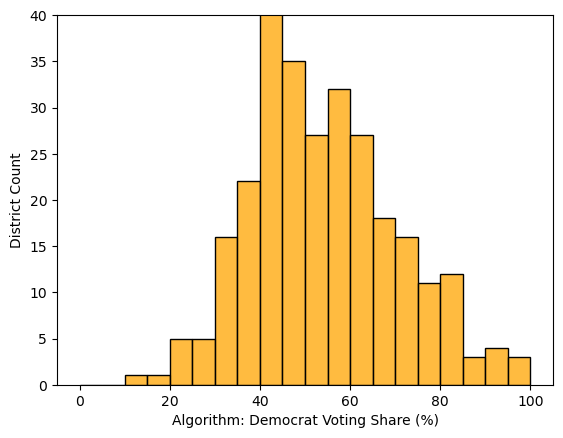

In [9]:

g = sns.histplot(x=algo_dems,bins=[i for i in range(0,101,5)], color="orange")
g.set(xlabel="Algorithm: Democrat Voting Share (%)")
g.set(ylabel="District Count")
plt.ylim(0,40)

(0.0, 40.0)

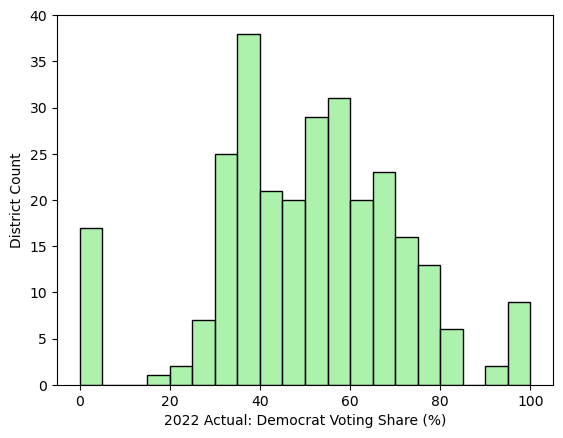

In [10]:
g = sns.histplot(x=[y*100 for y in act_dems],bins=[i for i in range(0,101,5)], color="lightgreen")
g.set(xlabel="2022 Actual: Democrat Voting Share (%)")
g.set(ylabel="District Count")
plt.ylim(0,40)

(0.0, 40.0)

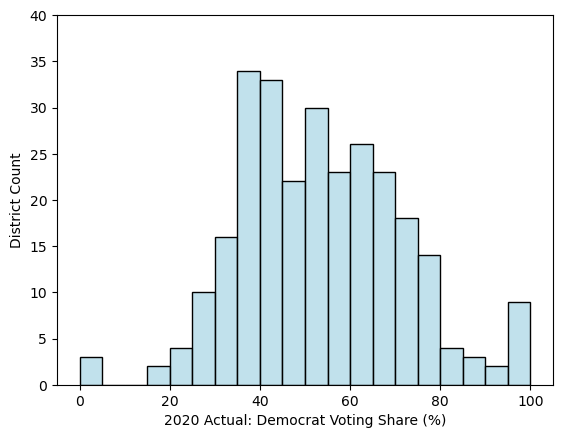

In [11]:
results_2020 = pd.read_excel("../redistricting/2020_congressional_voting_results.xlsx")
results_2020["dem"] = results_2020["dem"]*100
g = sns.histplot(x=results_2020["dem"],bins=[i for i in range(0,101,5)], color="lightblue")
g.set(xlabel="2020 Actual: Democrat Voting Share (%)")
g.set(ylabel="District Count")
plt.ylim(0,40)